**Setting up the environment**

In [77]:
%%capture
files = !ls
files = [f.split("  ") for f in files][0]

isFRIQML = 'fri_qml' in files
isFRIQMLPath = isFRIQML and "setup.py" in files

# Clone the entire repo. Only run once!
if not isFRIQML:
  !git clone -l -s https://github.com/znajob/fri_qml.git fri_qml

if not isFRIQMLPath:
  %cd fri_qml

!git pull
!pip install -e .

In [78]:
# MAIN IMPORTS
import pennylane as qml
from pennylane import numpy as np
from friqml.visualisation import plot_quantum_state, plot_histogram
from friqml.utils import eps, random_state_normalized, random_state_unnormalized
from functools import partial
from tqdm.notebook import tqdm
from friqml.utils import eps

When solving the exercises refer to the [PennyLane documentation](https://pennylane.readthedocs.io/en/stable/).

Pennylane [LCU and block encoding](https://pennylane.ai/qml/demos/tutorial_lcu_blockencoding#block-encodings)

# Block encoding

## Exercise 1

Linear combinations of unitaries (LCUs) are decompositions of matrices into a weighted sum of unitaries. More precisely, this means expressing a matrix $A$ in terms of coefficients $\alpha_k$ and unitaries $U_k$ as:

$$A = \sum_{k=0}^{N-1} \alpha_k U_k$$

A general way to build LCUs is to employ properties of the Pauli basis. This is the set of all products of Pauli matrices:

$$
\{I, X, Y, Z\}
$$

For the space of operators acting on $n$ qubits, this set forms a complete basis. Thus, any operator can be expressed in the Pauli basis, which immediately gives an LCU decomposition.

Write a `pauli_decompose(A)` function which returns the coefficients $\alpha_k$ and the corresponding Pauli strings of a Pauli decomposition of a matrix `A`.

In [89]:
from itertools import product

paulis_1q = {
    'I': np.array([[1, 0], [0, 1]], dtype=complex),
    'X': np.array([[0, 1], [1, 0]], dtype=complex),
    'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
    'Z': np.array([[1, 0], [0, -1]], dtype=complex)
}

def get_pauli_strings(nqubits):
    """Generate all possible Pauli strings for nqubits."""
    paulis = ['I', 'X', 'Y', 'Z']
    return [''.join(p) for p in product(paulis, repeat=nqubits)]


def pauli_word_to_operator(word, wires):
    """Convert a Pauli word to a PennyLane operator."""
    op = qml.Identity(wires=wires[0])  # start with identity
    for i, pauli in enumerate(word):
        if pauli == 'I':
            continue
        elif pauli == 'X':
            op = op @ qml.PauliX(wires=wires[i])
        elif pauli == 'Y':
            op = op @ qml.PauliY(wires=wires[i])
        elif pauli == 'Z':
            op = op @ qml.PauliZ(wires=wires[i])
    return op

def pauli_matrix_from_string(s):
    """Generate full matrix from Pauli string (e.g. 'IXZ')."""
    mat = paulis_1q[s[0]]
    pw = {}
    if s[0] != "I":
        pw[0] = s[0]
    for i, c in enumerate(s[1:]):
        mat = np.kron(mat, paulis_1q[c])
        if c != "I":
            pw[i+1] = c
    return mat

def pauli_decompose(matrix):
    """Decomposes a Hermitian matrix into Pauli strings."""
    n = int(np.log2(matrix.shape[0]))
    if matrix.shape != (2**n, 2**n):
        raise ValueError("Matrix must be 2^n x 2^n in size.")
    if not np.allclose(matrix, matrix.conj().T):
        raise ValueError("Matrix must be Hermitian.")

    coeffs = []
    pstrings = []
    for p_str in get_pauli_strings(n):
        P = pauli_matrix_from_string(p_str)
        # real part only; Hermitian ensures imaginary ~0
        alpha = np.trace(P @ matrix).real / (2**n)
        if not np.isclose(alpha, 0):
            coeffs.append(alpha)
            pstrings.append(p_str)
    return coeffs, pstrings

In [90]:
# TESTS
nqubits = 2
nalphas = 3

# Random hermitian matrix with positive coefficients
all_pauli_strings = list(get_pauli_strings(nqubits))
pauli_strings = np.random.choice(all_pauli_strings,nalphas,replace=False)
coeffs = 3*np.random.rand(nalphas)
# coeffs = coeffs/np.sum(abs(coeffs))

# matrix to be decomposed
A = 0
for c,s in zip(coeffs,pauli_strings):
  A += c*pauli_word_to_operator(str(s),wires=[0,1]).matrix()

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()
LCU_terms = [op.matrix() for op in LCU_ops]

alphas, pws = pauli_decompose(A)

print((LCU_coeffs==alphas))
print([np.allclose(op1.matrix(),pauli_word_to_operator(op2,wires=[0,1]).matrix()) for op1,op2 in zip(LCU_ops,pws)])

[ True  True  True]
[True, True, True]


## Exercise 2
We implement the LCU as a quantum circuit by applying the **prepare** and **select** unitaries.

Starting from the LCU decomposition (see Exercise 1) with positive, real coefficients $ \alpha_k $, we define the **prepare** (`PREP`) operator as:

$$
\text{PREP} \, |0\rangle = \sum_k \frac{\sqrt{|\alpha_k|}}{\sqrt{\lambda}} \, |k\rangle
$$

where $ \lambda $ is a normalization constant:

$$
\lambda = \sum_k |\alpha_k|
$$

The **select** (`SEL`) operator is defined by:

$$
\text{SEL} \, |k\rangle |\psi\rangle = |k\rangle U_k |\psi\rangle
$$

Write the templates `select(pauli_strings, wires, wires_aux)` and `prep(alphas, wires_aux)` that implement the `SEL` and `PREP` unitaries. The argument `pauli_strings` is a list of pauli strings acting on qubits defined by the argument `wires`. The argument `wires_aux` determines the auxiliary qubits for `PREP` and `SEL` unitaries. The minimum number of auxiliary qubits is determined by the number of terms in the LCU decomposition and should be calculated on the fly.

In [92]:
def prep(alphas, wires):
    qml.StatePrep(alphas, wires=wires, pad_with=0)

def select(pauli_strings, wires, wires_aux):
    """Apply unitary U_k to wires, controlled by wires_aux in |k⟩."""
    ops = [pauli_word_to_operator(p, wires=wires) for p in pauli_strings]
    qml.Select(ops, control=wires_aux)

In [93]:
# TESTS

alpha_prep = np.sqrt((alphas/np.sum(np.abs(alphas))).astype(complex))

a=int(np.ceil(np.log2(len(alpha_prep))))
n=int(np.ceil(np.log2(len(A))))

# DEVICE
dev = qml.device('default.qubit', wires=a, shots=None)
@qml.qnode(dev)
def circuit_prep(alphas):
  wires = range(a)
  prep(alphas,wires)
  return qml.state()

print(np.array([np.allclose(a1,a2) for a1,a2 in zip(circuit_prep(alpha_prep),alpha_prep)]).all())

# DEVICE
dev = qml.device('default.qubit', wires=a+n, shots=None)
@qml.qnode(dev)
def circuit_sel():
  wires = range(n)
  wires_aux = range(n,a+n)
  prep(alpha_prep,wires_aux)
  select(pws,wires=wires,wires_aux=wires_aux)
  return qml.state()

dev = qml.device('default.qubit', wires=a+n, shots=None)
@qml.qnode(dev)
def circuit_sel_pennylane():
  wires = range(n)
  wires_aux = range(n,a+n)
  prep(alpha_prep,wires_aux)
  unitaries = [pauli_word_to_operator(pw,wires=wires) for pw in pws]
  qml.Select(unitaries, control=wires_aux)
  return qml.state()

print(np.array([np.allclose(a1,a2) for a1,a2 in zip(circuit_sel(),circuit_sel_pennylane())]).all())


True
True


## Exercise 3


In [95]:
def block_encoding(A, wires, wires_aux):
    coeffs, pauli_strings = pauli_decompose(A)
    coeffs = np.array(coeffs, dtype=complex)
    coeffs_normalized = np.sqrt(coeffs/np.sum(np.abs(coeffs)))
    n = int(np.log2(len(A)))
    a = int(np.ceil(np.log2(len(coeffs))))

    qml.StatePrep(coeffs_normalized, wires_aux, pad_with=0)
    select(pauli_strings, wires=wires, wires_aux=wires_aux)
    qml.adjoint(qml.StatePrep(coeffs_normalized, wires_aux, pad_with=0))


In [96]:
# TESTS

a=int(np.ceil(np.log2(len(alpha_prep))))
n=int(np.ceil(np.log2(len(A))))

wires_aux = range(a)
wires = range(a,a+n)

dev = qml.device('default.qubit', wires=a+n, shots=None)
@qml.qnode(dev)
def circuit_block_encoding():
  block_encoding(A,wires,wires_aux)
  return qml.state()

output_matrix = qml.matrix(circuit_block_encoding)()
print("A:\n", np.round(A/np.sum(alphas),3), "\n")
print("Block-encoded A:\n")
print(np.round(output_matrix[:4,:4],3),"\n")
print("Norm difference\n")
print(np.linalg.norm(A/np.sum(alphas)-output_matrix[:4,:4]))

A:
 [[ 0.   +0.j     0.202+0.j     0.574+0.j     0.   -0.223j]
 [ 0.202+0.j     0.   +0.j     0.   -0.223j -0.574+0.j   ]
 [ 0.574+0.j     0.   +0.223j  0.   +0.j     0.202+0.j   ]
 [ 0.   +0.223j -0.574+0.j     0.202+0.j     0.   +0.j   ]] 

Block-encoded A:

[[ 0.   +0.j     0.202+0.j     0.574+0.j     0.   -0.223j]
 [ 0.202+0.j     0.   +0.j     0.   -0.223j -0.574+0.j   ]
 [ 0.574+0.j     0.   +0.223j  0.   +0.j     0.202+0.j   ]
 [ 0.   +0.223j -0.574+0.j     0.202+0.j     0.   +0.j   ]] 

Norm difference

2.830524433501838e-16


# Exponential encoding

## Exercise 1
Prepare the template `variational_layer(weights,wires)` which consists of `RY` rotations followed by `CNOTS`. The argument `weights` stores the angles of the rotations and `wires` denotes the wires on which the template is acting.

In [98]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

In [99]:
def variational_layer(weights, wires):
    n_qubits = len(weights)
    for i in range(n_qubits):
        qml.RX(weights[i, 0], wires=wires[i])
        qml.RY(weights[i, 1], wires=wires[i])
        qml.RZ(weights[i, 2], wires=wires[i])
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[wires[i], wires[i+1]])


In [100]:
# TESTS

@qml.qnode(dev)
def test_var(weights):
    variational_layer(weights,wires=range(len(weights)))
    return qml.state()

print(qml.draw(test_var)(np.random.rand(n_qubits,3)))

0: ──RX(0.96)──RY(0.25)──RZ(0.50)─╭●────┤  State
1: ──RX(0.30)──RY(0.28)──RZ(0.04)─╰X─╭●─┤  State
2: ──RX(0.61)──RY(0.50)──RZ(0.05)────╰X─┤  State


## Exercise 2
Write the template `exponential_encoding(x,wires)` with arguments `x` a real input and `wires` list of wires on which the input is encoded. You should use rotations around the `x` axis. Also, write a template `parallel_pauli_encoding(x,wires)` which uses a fixed angle $2 \pi x$ for each rotation.

In [102]:
def exponential_encoding(x, wires):
    for i, w in enumerate(wires):
        qml.RX(3**i * x, wires=w)


def parallel_pauli_encoding(x, wires):
    for i, w in enumerate(wires):
        qml.RX(2*np.pi * x, wires=w)


In [103]:
# TESTS

@qml.qnode(dev)
def test_encoding(x):
    exponential_encoding(x, range(n_qubits))
    return qml.state()

print(qml.draw(test_encoding)(np.pi / 4))


0: ──RX(0.79)─┤  State
1: ──RX(2.36)─┤  State
2: ──RX(7.07)─┤  State


## Exercise 3
Implement and compare two parameterized quantum circuits (PQCs) for fitting a target function using a single input parameter `x`.

The first PQC should use the template `pqc_exponential(x,weights)` which should have variable number of interchanging `variational_layer` and `exponential_encoding` layers and should return the expectation value of a chosen operator.

The second `pqc_parallel_pauli(x,weights)` should have exactly the same structure as `pqc_exponential` only the exponential encoding layer should be replaced with the `parallel_pauli_encoding` layer.

In both cases the `weights` trainable parameters should have the dimension $n_{\rm layers} \times n_{\rm qubits} \times 3$. The last dimension three is related to the rotation angles in the variational_layer

Fit the models and plot the solutions.

**Example of PQC with 3 qubits and 4 layers**
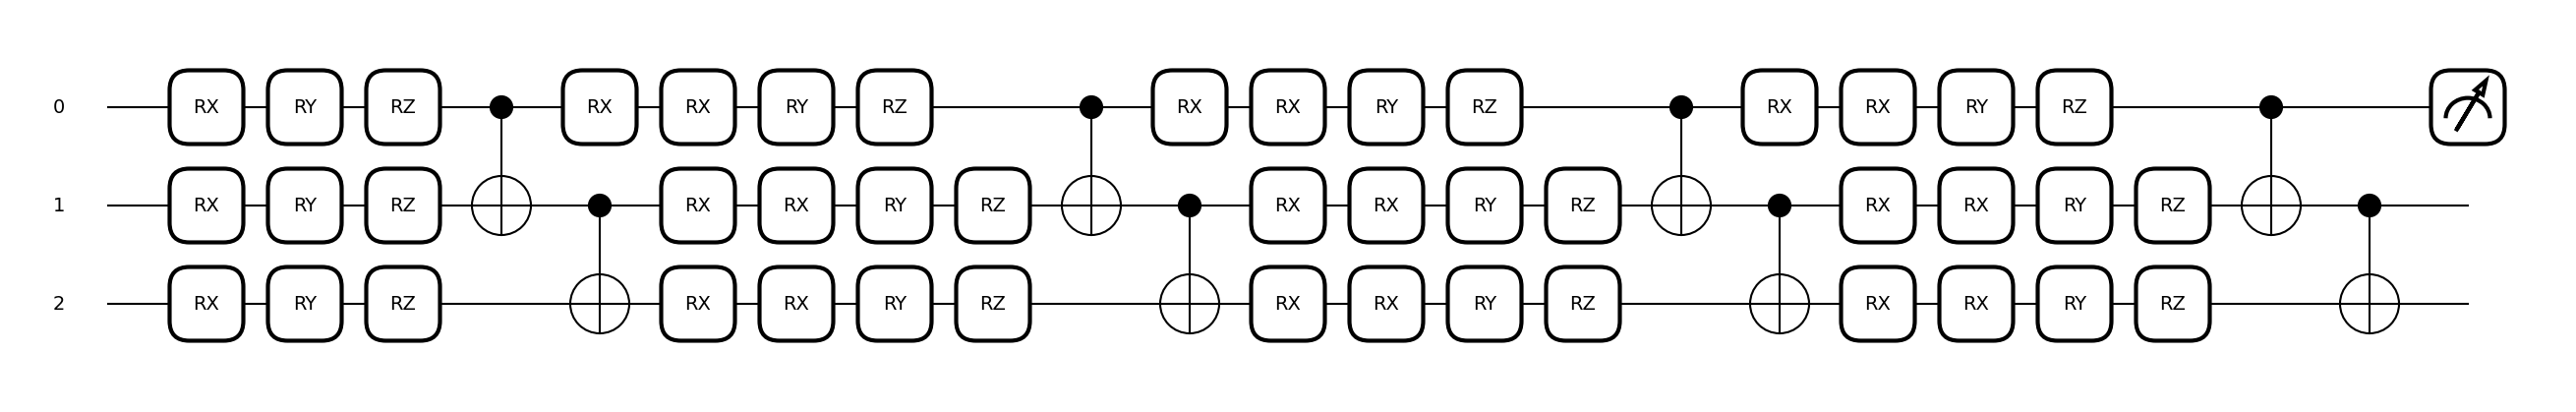

In [105]:
from pennylane.optimize import AdamOptimizer
from tqdm.notebook import tqdm

In [106]:
def target_function(x):
    return (
        0.6 * np.sin(2 * x)
        + 0.3 * np.sin(5 * x + 0.5)
        + 0.1 * np.sin(9 * x + 1.0)
    )

In [107]:
def pqc_exponential(x, weights):
    n_qubits = len(weights[0])
    variational_layer(weights[0], range(n_qubits))
    for wl in weights[1:]:
        exponential_encoding(x, range(n_qubits))
        variational_layer(wl, range(n_qubits))
    return qml.expval(qml.PauliZ(0))


def pqc_parallel_pauli(x, weights):
    n_qubits = len(weights[0])
    variational_layer(weights[0], range(n_qubits))
    for wl in weights[1:]:
        parallel_pauli_encoding(x, range(n_qubits))
        variational_layer(wl, range(n_qubits))
    return qml.expval(qml.PauliZ(0))


In [108]:
# Defining the model
@qml.qnode(dev)
def exponential_model(x,weights):
  return pqc_exponential(x,weights)

@qml.qnode(dev)
def parallel_pauli_model(x,weights):
  return pqc_parallel_pauli(x,weights)

In [109]:
# Dataset
X = np.linspace(0, 2*np.pi, 100)
Y = np.array([target_function(x) for x in X])

In [110]:
# Exponential model fit

# Parameters
np.random.seed(42)
nlayers = 4
weights = np.random.randn(nlayers, n_qubits, 3, requires_grad=True)
opt = AdamOptimizer(stepsize=0.05)

steps = 100
losses = []

# Cost function
def cost(w):
    preds = np.array([exponential_model(x, w) for x in X])
    return np.mean((preds - Y)**2)

# Training
for _ in tqdm(range(steps)):
    weights = opt.step(cost, weights)
    losses.append(cost(weights))

  0%|          | 0/100 [00:00<?, ?it/s]

In [111]:
# Parallel Pauli model fit

# Parameters
np.random.seed(42)
nlayers = 4
weights_pauli = np.random.randn(nlayers, n_qubits, 3, requires_grad=True)
opt = AdamOptimizer(stepsize=0.05)

steps = 100
losses_pauli = []

# Cost function
def cost(w):
    preds = np.array([parallel_pauli_model(x, w) for x in X])
    return np.mean((preds - Y)**2)

# Training
for _ in tqdm(range(steps)):
    weights_pauli = opt.step(cost, weights_pauli)
    losses_pauli.append(cost(weights_pauli))

  0%|          | 0/100 [00:00<?, ?it/s]

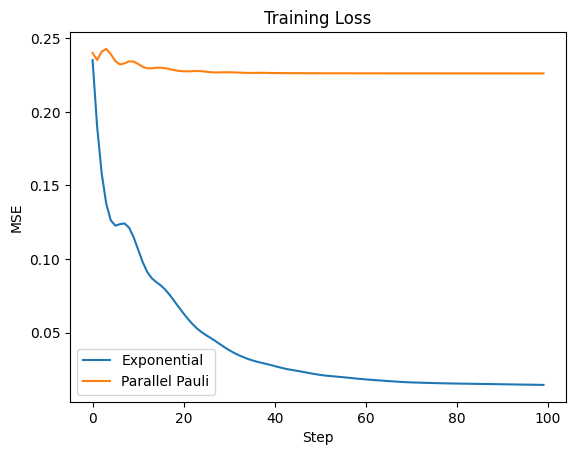

In [112]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Exponential")
plt.plot(losses_pauli,label="Parallel Pauli")
plt.legend()
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.show()


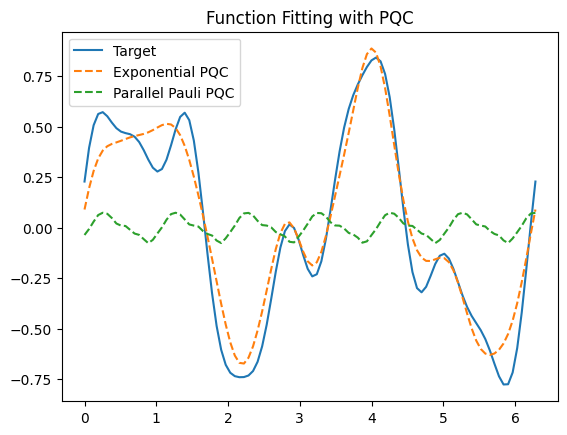

In [113]:
Y_pred = np.array([exponential_model(x, weights) for x in X])
Y_pred_pauli = np.array([parallel_pauli_model(x, weights_pauli) for x in X])

plt.plot(X, Y, label="Target")
plt.plot(X, Y_pred, "--", label="Exponential PQC")
plt.plot(X, Y_pred_pauli, "--", label="Parallel Pauli PQC")
plt.legend()
plt.title("Function Fitting with PQC")
plt.show()

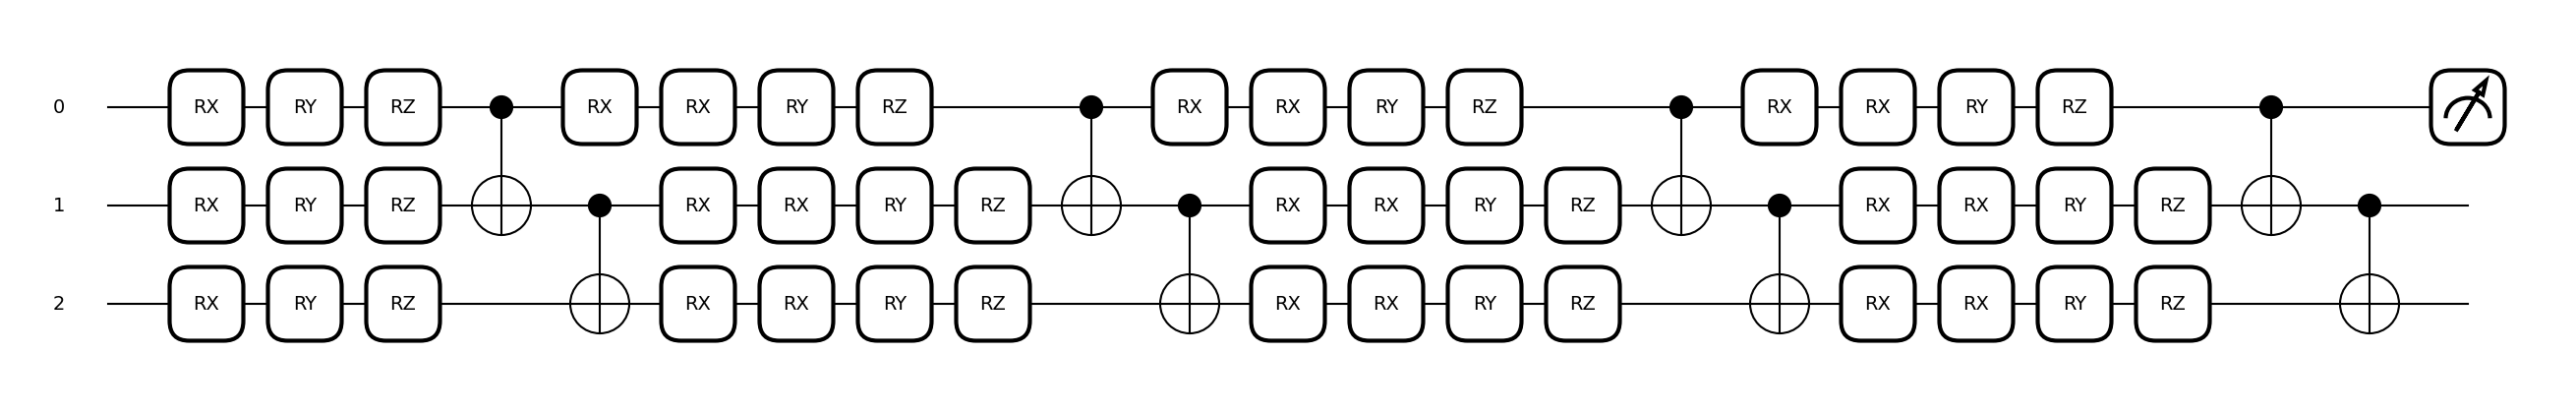

In [114]:
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(parallel_pauli_model)(0.4, weights)